In [1]:
using Turing, Zygote, Random, Plots, Distributions, LinearAlgebra, StatsPlots, Transits, Optim

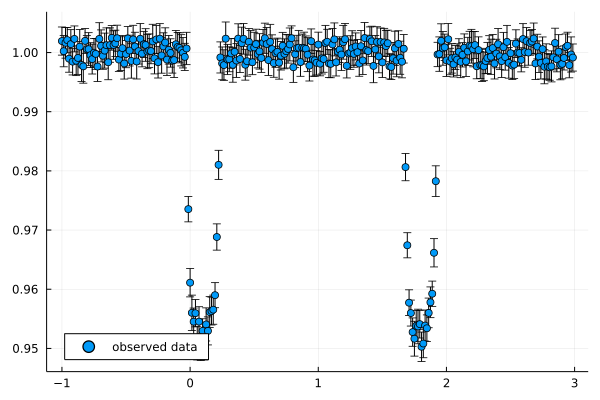

In [2]:
# time (288 data points)
ts = range(-1, 3, step=0.01389) 

ror = 0.2
u_n = [0.4, 0.25]
dur=0.25
per=1.7
t0 = 0.1


lightcurve(X) = compute(QuadLimbDark(X[6:end]), SimpleOrbit(period=X[2], duration=X[3], t0=X[5]), X[1], X[4])

flux = [lightcurve([t, per, dur, ror, t0, u_n...]) for t in ts]


fluxerr = 0.001*rand(length(ts)) .+ 0.002

y = flux .+ .005*(rand(length(ts)).-0.5)

#sigma
scatter(ts, y, yerr=fluxerr, label="observed data", legend=:bottomleft)

In [7]:
Turing.setadbackend(:zygote)

# Declare our Turing model.
@model function lin_reg(y, sigma)
    # Prior
    t1 ~ Uniform(0.0, 0.2)
    d1 ~ Uniform(0.15, 0.30)
    r1 ~ Uniform(0.1, 0.25)
    p1 ~ Uniform(1.6, 1.9)

    #d1 ~ Normal(0.2, 0.2)

    if 2*d1 >= p1
        Turing.@addlogprob! -Inf
        # Exit the model evaluation early
        return
    end
    # The number of observations.
    N = length(y)
    for i in 1:N
        # Likelihood
        y[i] ~ Normal(lightcurve([ts[i], p1, d1, r1, t1, u_n...]), sigma[i])
    end
end

# Settings of the  sampler.
iterations = 500


# Generate a MAP estimate.
model = lin_reg(y, fluxerr)
map_estimate = optimize(model, MAP())
println(map_estimate)

#map_est = map_estimate.values.array .+ 1e-2*rand(length(map_estimate.values.array))
#println(map_est)


[0.10004595101039325, 0.25006658141309196, 0.19999876961758933, 1.6996056465038716]


In [8]:
# Start sampling.
chain = sample(lin_reg(y, fluxerr), NUTS(), iterations, init_params = map_estimate.values.array)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/hossein/.julia/packages/Turing/Ir2iS/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:02


Chains MCMC chain (500×16×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 345.8 seconds
Compute duration  = 345.8 seconds
parameters        = t1, d1, r1, p1
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          t1    0.1003    0.0012     0.0001    0.0001   286.4482    0.9991     ⋯
          d1    0.2500    0.0019     0.0001    0.0001   276.1084    1.0016     ⋯
          r1    0.2001    0.0010     0.0000    0.0000   355.9205    1.0005     ⋯
          p1    1.6995    0.0017     0.0001    0.0001   322.4957    0.9992     ⋯
                                                             

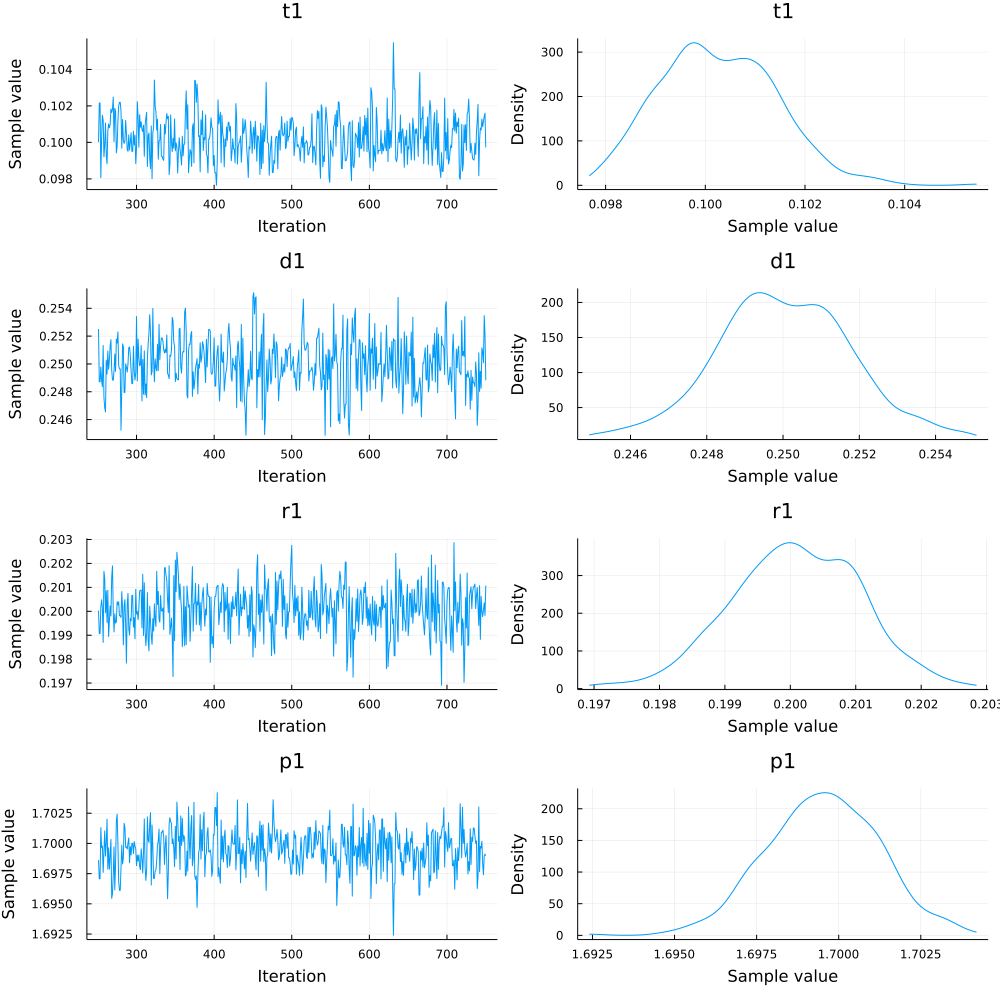

In [9]:
plot(chain)

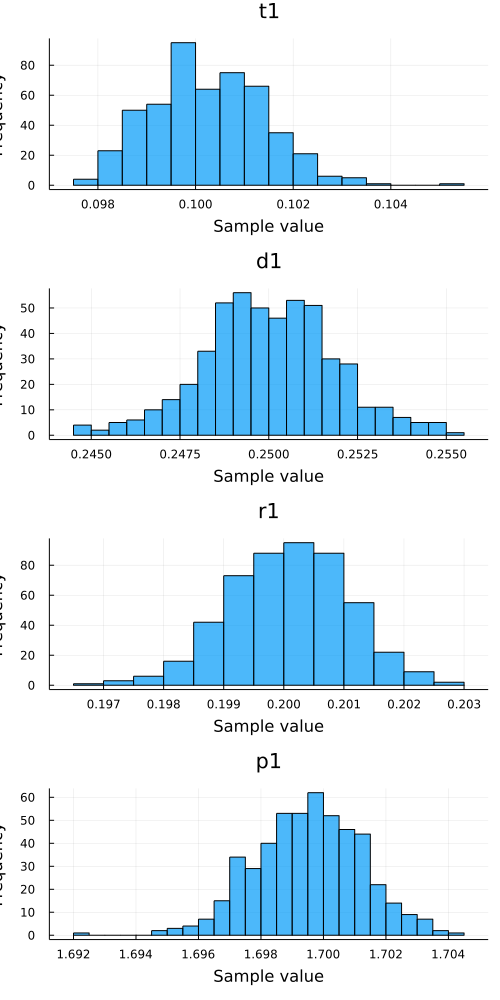

In [10]:
histogram(chain)

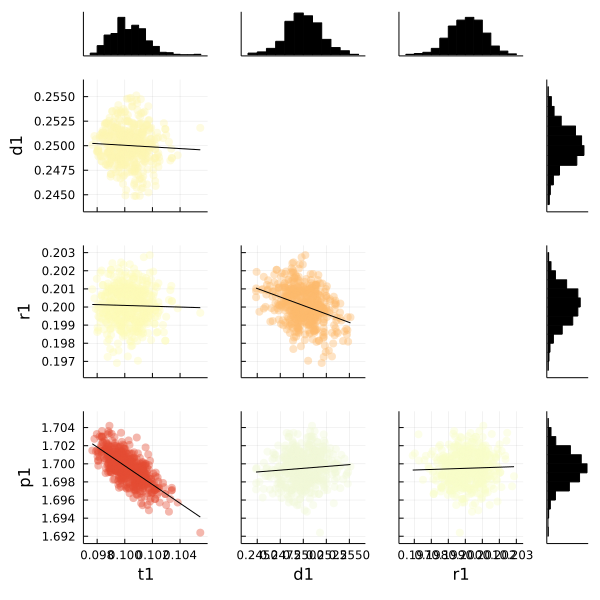

In [11]:
corner(chain)

In [12]:
mean(chain)
#println(mean(chain))

Mean
  parameters      mean 
      Symbol   Float64 

          t1    0.1003
          d1    0.2500
          r1    0.2001
          p1    1.6995


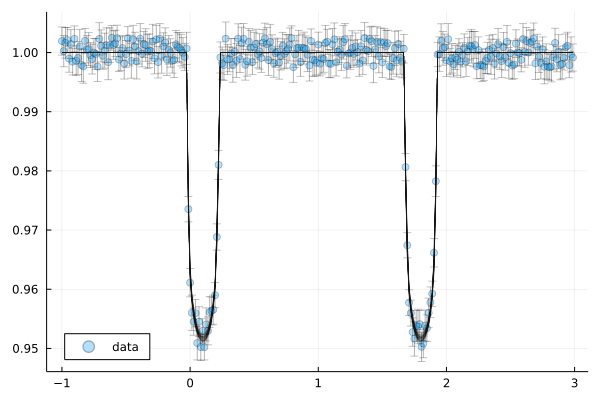

In [16]:
plt = scatter(ts, y, yerr=fluxerr, alpha=0.3, label="data", legend=:bottomleft)
#println(mean(chain[:t1]))

#plot!(ts, [lightcurve([t , per, mean(chain[:d1]), mean(chain[:r1]), mean(chain[:t1]), u_n...]) for t in ts], label="fitted model", legend=:bottomleft)

for i in length(chain[:d1]):-1:length(chain[:d1])-250
    #println(chain[:a1][i])
    #plot!(plt, x, chain[:a1][i]*x .+ chain[:b1][i] , alpha=0.02, label = "")
    plot!(plt, ts, [lightcurve([t , per, chain[:d1][i], chain[:r1][i], chain[:t1][i], u_n...]) for t in ts], alpha=0.05, 
    label="", color="black", lw=0.5)

end
plt